In [ ]:
!pip install torchrl

# Importing libraries

In [3]:
import torch
from torch import nn
from torchrl.envs import (
    GymEnv,
    Compose,
    TransformedEnv,
    ToTensorImage,
    GrayScale,
    StepCounter,
    Resize,
    InitTracker,
    RewardScaling,
    ObservationNorm,
    set_exploration_type,
    ExplorationType
)
from tensordict.nn import TensorDictModule, TensorDictSequential
import matplotlib.pyplot as plt
from torchrl.modules import ConvNet, EGreedyModule, LSTMModule, MLP, QValueModule
from torchrl.objectives import DQNLoss, SoftUpdate
from torchrl.data import LazyMemmapStorage, TensorDictReplayBuffer
from torchrl.collectors import SyncDataCollector

import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Selected device is {device}')

Selected device is cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Environment

In [5]:
base_env = GymEnv(
    env_name='CartPole-v1',
    from_pixels=True,
    pixels_only=False,
    device=device
)
env = TransformedEnv(
    env=base_env,
    transform=Compose(
        ToTensorImage(),
        GrayScale(),
        Resize(84,84),
        StepCounter(),
        InitTracker(),
        RewardScaling(loc=0.0, scale=0.1),
        ObservationNorm(standard_normal=True, in_keys=['pixels'])
    )
)
env.transform[-1].init_stats(1000, reduce_dim=[0, 1, 2], cat_dim=0, keep_dims=[0])

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

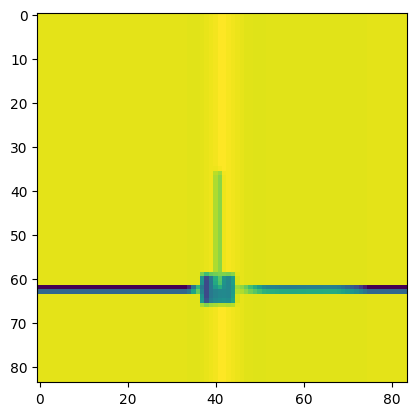

In [8]:
td = env.reset()
plt.imshow(td['pixels'].cpu().squeeze())

# Agent

In [9]:
feature = TensorDictModule(
    ConvNet(
        num_cells=[32, 32, 64],
        squeeze_output=True,
        aggregator_class=nn.AdaptiveAvgPool2d,
        aggregator_kwargs={"output_size": (1, 1)},
        device=device,
    ),
    in_keys=["pixels"],
    out_keys=["embed"],
)

In [10]:
n_cells = feature(env.reset())['embed'].shape[-1]

In [11]:
lstm = LSTMModule(
    input_size=n_cells,
    hidden_size=128,
    device=device,
    in_key='embed',
    out_key='embed'
)

In [12]:
print('in_keys: '), lstm.out_keys

in_keys: 


(None, ['embed', ('next', 'recurrent_state_h'), ('next', 'recurrent_state_c')])

In [13]:
env.append_transform(lstm.make_tensordict_primer())

TransformedEnv(
    env=GymEnv(env=CartPole-v1, batch_size=torch.Size([]), device=cuda:0),
    transform=Compose(
            ToTensorImage(keys=['pixels']),
            GrayScale(keys=['pixels']),
            Resize(w=84, h=84, interpolation=InterpolationMode.BILINEAR, keys=['pixels']),
            StepCounter(keys=[]),
            InitTracker(keys=[]),
            RewardScaling(loc=0.0000, scale=0.1000, keys=['reward']),
            ObservationNorm(keys=['pixels']),
            TensorDictPrimer(primers=Composite(
                recurrent_state_h: UnboundedContinuous(
                    shape=torch.Size([1, 128]),
                    space=ContinuousBox(
                        low=Tensor(shape=torch.Size([1, 128]), device=cuda:0, dtype=torch.float32, contiguous=True),
                        high=Tensor(shape=torch.Size([1, 128]), device=cuda:0, dtype=torch.float32, contiguous=True)),
                    device=cuda:0,
                    dtype=torch.float32,
                    do

In [14]:
mlp = MLP(
    out_features=2,
    num_cells=[64,],
    device=device
)

In [15]:
mlp[-1].bias.data.fill_(0.0)

tensor([0., 0.], device='cuda:0')

In [16]:
mlp = TensorDictModule(
    module=mlp,
    in_keys=['embed'],
    out_keys=['action_value']
)

In [17]:
mlp

TensorDictModule(
    module=MLP(
      (0): LazyLinear(in_features=0, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=2, bias=True)
    ),
    device=cuda:0,
    in_keys=['embed'],
    out_keys=['action_value'])

In [18]:
qval = QValueModule(action_space=None, spec=env.action_spec)

In [19]:
stoch_policy = TensorDictSequential(feature, lstm, mlp, qval)

In [20]:
exploration_module = EGreedyModule(
    annealing_num_steps=1_000_000, spec=env.action_spec, eps_init=0.2
)
stoch_policy = TensorDictSequential(
    stoch_policy,
    exploration_module,
)

In [21]:
policy = TensorDictSequential(feature, lstm.set_recurrent_mode(True), mlp, qval)

In [22]:
policy(env.reset())

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2]), device=cuda:0, dtype=torch.int64, is_shared=True),
        action_value: Tensor(shape=torch.Size([2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        chosen_action_value: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        embed: Tensor(shape=torch.Size([128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        is_init: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                recurrent_state_c: Tensor(shape=torch.Size([1, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
                recurrent_state_h: Tensor(shape=torch.Size([1, 128]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([]),
            device=cuda:0,
          

In [23]:
loss_fn = DQNLoss(policy, action_space=env.action_spec, delay_value=True)

In [24]:
updater = SoftUpdate(loss_fn, eps=0.95)

In [25]:
optim = torch.optim.Adam(policy.parameters(), lr=3e-4)

In [38]:
collector = SyncDataCollector(env, stoch_policy, frames_per_batch=50, total_frames=200)
rb = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(1_000_000), batch_size=4, prefetch=10
)

In [39]:
utd = 16
pbar = tqdm.tqdm(total=collector.total_frames)
longest = 0

traj_lens = []
for i, data in enumerate(collector):
    if i == 0:
        print(
            "Let us print the first batch of data.\nPay attention to the key names "
            "which will reflect what can be found in this data structure, in particular: "
            "the output of the QValueModule (action_values, action and chosen_action_value),"
            "the 'is_init' key that will tell us if a step is initial or not, and the "
            "recurrent_state keys.\n",
            data,
        )
    pbar.update(data.numel())
    # it is important to pass data that is not flattened
    rb.extend(data.unsqueeze(0).to_tensordict().cpu())
    for _ in range(utd):
        s = rb.sample().to(device, non_blocking=True)
        loss_vals = loss_fn(s)
        loss_vals["loss"].backward()
        optim.step()
        optim.zero_grad()
    longest = max(longest, data["step_count"].max().item())
    pbar.set_description(
        f"steps: {longest}, loss_val: {loss_vals['loss'].item(): 4.4f}, action_spread: {data['action'].sum(0)}"
    )
    exploration_module.step(data.numel())
    updater.step()

    with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
        rollout = env.rollout(10000, stoch_policy)
        traj_lens.append(rollout.get(("next", "step_count")).max().item())

steps: 46, loss_val:  0.0128, action_spread: tensor([10, 40], device='cuda:0'):   1%|          | 6000/1000000 [07:09<19:45:26, 13.98it/s]
 25%|██▌       | 50/200 [00:00<00:01, 128.65it/s]

Let us print the first batch of data.
Pay attention to the key names which will reflect what can be found in this data structure, in particular: the output of the QValueModule (action_values, action and chosen_action_value),the 'is_init' key that will tell us if a step is initial or not, and the recurrent_state keys.
 TensorDict(
    fields={
        action: Tensor(shape=torch.Size([50, 2]), device=cuda:0, dtype=torch.int64, is_shared=True),
        action_value: Tensor(shape=torch.Size([50, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        chosen_action_value: Tensor(shape=torch.Size([50, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([50]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([50]),
            device=None,
            is_shared=False),
        done: Tensor(shape=torch.Size([50, 1]), device=cuda:0, dtype=torch

steps: 18, loss_val:  0.0149, action_spread: tensor([21, 29], device='cuda:0'):  25%|██▌       | 50/200 [00:03<00:01, 128.65it/s]/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
steps: 28, loss_val:  0.0168, action_spread: tensor([19, 31], device='cuda:0'): 100%|██████████| 200/200 [00:12<00:00, 18.23it/s]

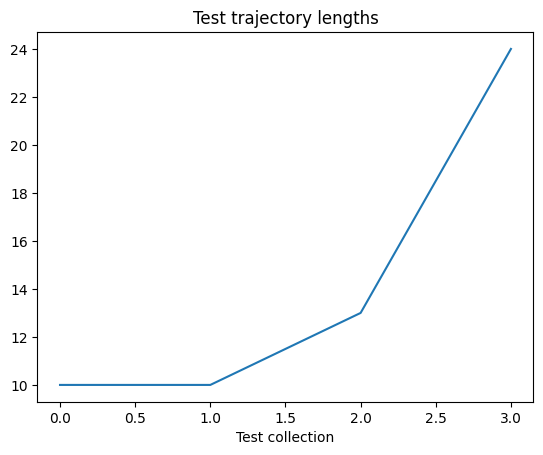

In [40]:
if traj_lens:
    from matplotlib import pyplot as plt

    plt.plot(traj_lens)
    plt.xlabel("Test collection")
    plt.title("Test trajectory lengths")